In [6]:
import sys
sys.path.append('../')
from low_rank_rnns.modules import *
import matplotlib
import matplotlib.pyplot as plt
from low_rank_rnns import dms, ranktwo, clustering, helpers
import seaborn as sns

In [7]:
helpers.setup_matplotlib(release=True)

In [8]:
def time_mapping(t):
    return t * dms.deltaT / 1000

In [10]:
hidden_size = 4096
noise_std = 5e-2
alpha = 0.2
x_train, y_train, mask_train, x_val, y_val, mask_val = dms.generate_dms_data(1000)
net =  LowRankRNN(2, hidden_size, 1, noise_std, alpha, rank=2)
net.load_state_dict(torch.load(f'../models/dms_rank2_{hidden_size}.pt', map_location='cpu'))
net.svd_reparametrization()

In [11]:
loss_orig, acc_orig = dms.test_dms(net, x_val, y_val, mask_val)
print(acc_orig)

1.0


In [12]:
m1 = net.m[:,0].detach().numpy()
m2 = net.m[:,1].detach().numpy()
n1 = net.n[:,0].detach().numpy()
n2 = net.n[:,1].detach().numpy()
wi1 = net.wi_full[0].detach().numpy()
wi2 = net.wi_full[1].detach().numpy()
wo = net.wo_full[:,0].detach().numpy()

In [13]:
n_pops = 2
vecs = [n1, n2, m1, m2, wi1, wi2]
z, model = clustering.gmm_fit(vecs, n_pops, algo='bayes', n_init=50, random_state=2020, mean_precision_prior=1e5)
colors = ['seagreen', 'rebeccapurple']

Text(0.5, -8, 'speed')

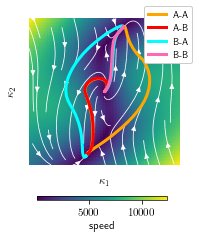

In [15]:
dms.decision_duration = 2000
dms.setup()
fig, ax = plt.subplots(figsize=(3, 3))
mappable = dms.plot_trajectories_summary_ranktwo(net, rect=(-3, 3, -3, 3), legend=False, 
                                                 figsize=(2.7, 2.7), timepoints=False, ax=ax)
ax.set_xlabel('$\kappa_1$')
ax.set_ylabel('$\kappa_2$')
ax.legend(loc='upper right', framealpha=1, frameon=True, bbox_to_anchor=(1.05, 1.05), fontsize=9)
ax_cbar = fig.add_axes((.2, 0, .6, .02))
plt.colorbar(mappable, cax=ax_cbar, orientation='horizontal')
ax_cbar.set_title('speed', y=-8)
#plt.savefig('figures/5_dms_trajectories.pdf', bbox_inches='tight')

Text(0, 0.9, '$m_i^{(2)}$')

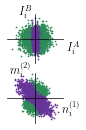

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(1, 2))
fs = 12

clustering.pop_scatter_linreg(wi1, wi2, z, 2, colors=colors, linreg=False, ax=ax[0])
ax[0].set_xlabel('$I_i^{A}$', horizontalalignment='right', x=1.3, fontsize=fs)
ax[0].set_ylabel('$I_i^{B}$', horizontalalignment='right', y=.9, rotation='horizontal', fontsize=fs)

clustering.pop_scatter_linreg(n1, m2, z, 2, colors=colors, linreg=False, ax=ax[1])
ax[1].set_xlabel('$n_i^{(1)}$', horizontalalignment='right', x=1.3, fontsize=fs)
ax[1].set_ylabel('$m_i^{(2)}$', horizontalalignment='right', y=.9, rotation='horizontal', fontsize=fs)
#plt.savefig('figures/5_dms_scatters.pdf', bbox_inches='tight')

# Saturation violin plots

In [17]:
dms.stimulus1_duration_min = 500
dms.stimulus1_duration_max = 500
dms.delay_duration_min = 1000
dms.delay_duration_max = 1000
dms.stimulus2_duration_min = 500
dms.stimulus2_duration_max = 500
dms.setup()
stim1_begin = dms.fixation_duration_discrete
stim1_end = stim1_begin + dms.min_stimulus1_duration_discrete
stim2_begin = dms.fixation_duration_discrete + dms.min_stimulus1_duration_discrete + dms.min_delay_duration_discrete
stim2_end = stim2_begin + dms.min_stimulus2_duration_discrete
x1, _, _, _, _, _ = dms.generate_dms_data(1, type='A-A')
outp, trajectories = net.forward(x1, return_dynamics=True)
trajectories = trajectories.detach().squeeze().numpy()
phi_primes1 = helpers.phi_prime(trajectories[stim1_begin:stim1_end].mean(axis=0))
x2, _, _, _, _, _ = dms.generate_dms_data(1, type='B-B')
outp, trajectories = net.forward(x2, return_dynamics=True)
trajectories = trajectories.detach().squeeze().numpy()
phi_primes2 = helpers.phi_prime(trajectories[stim1_begin:stim1_end].mean(axis=0))


phi_primes3 = helpers.phi_prime(trajectories[stim1_end:stim2_begin].mean(axis=0))

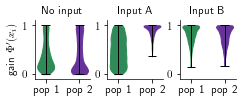

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(4*0.9, 1.2*.9))

pl = ax[0].violinplot([phi_primes3[z==i] for i in range(2)])
for i, violin in enumerate(pl['bodies']):
    violin.set_facecolor(colors[i])
    violin.set_edgecolor(colors[i])
    violin.set_alpha(1)
pl['cbars'].set_color('black')
pl['cmins'].set_color('black')
pl['cmaxes'].set_color('black')
ax[0].set_ylim(-.1, 1.1)
ax[0].set_yticks([0, 1])
ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(['pop 1', 'pop 2'])
ax[0].set_ylabel('gain $\Phi\'(x_i)$')
ax[0].set_title('No input')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

pl = ax[1].violinplot([phi_primes1[z==i] for i in range(2)])
for i, violin in enumerate(pl['bodies']):
    violin.set_facecolor(colors[i])
    violin.set_edgecolor(colors[i])
    violin.set_alpha(1)
pl['cbars'].set_color('black')
pl['cmins'].set_color('black')
pl['cmaxes'].set_color('black')
ax[1].set_ylim(-.1, 1.1)
ax[1].set_yticks([0, 1])
ax[1].set_xticks([1, 2])
ax[1].set_xticklabels(['pop 1', 'pop 2'])
ax[1].set_title('Input A')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

pl = ax[2].violinplot([phi_primes2[z==i] for i in range(2)])
for i, violin in enumerate(pl['bodies']):
    violin.set_facecolor(colors[i])
    violin.set_edgecolor(colors[i])
    violin.set_alpha(1)
pl['cbars'].set_color('black')
pl['cmins'].set_color('black')
pl['cmaxes'].set_color('black')
ax[2].set_ylim(-.1, 1.1)
ax[2].set_yticks([0, 1])
ax[2].set_xticks([1, 2])
ax[2].set_xticklabels(['pop 1', 'pop 2'])
ax[2].set_title('Input B')
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)

fig.subplots_adjust(wspace=.3)
#plt.savefig('figures/5_dms_violin.pdf', bbox_inches='tight')

# Overlap matrices

/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Use the colorbar set_ticks() method instead.


[Text(1, 0, '$-5$'), Text(1, 0, '$0$'), Text(1, 0, '$5$')]

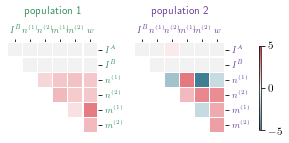

In [19]:
vecs = [wi1, wi2, n1, n2, m1, m2, wo]
labels = ['$I^A$', '$I^B$', '$n^{(1)}$', '$n^{(2)}$', '$m^{(1)}$', '$m^{(2)}$', '$w$']
lsize = 9

ov_pop1 = helpers.overlap_matrix([v[z==0] for v in vecs])
ov_pop2 = helpers.overlap_matrix([v[z==1] for v in vecs])
bound_pop1 = np.max((np.abs(np.min(ov_pop1)),np.abs(np.max(ov_pop1))))
bound_pop2 = np.max((np.abs(np.min(ov_pop2)),np.abs(np.max(ov_pop2))))
overall_bound = np.max((bound_pop1,bound_pop2))

fig, ax = plt.subplots(1, 2, figsize=(0.65 * 6, 0.65 * 3))
helpers.get_lower_tri_heatmap(ov_pop1, bounds=[-overall_bound, overall_bound], ax=ax[0])
ax[0].set_xticklabels(labels[1:], color='seagreen')
ax[0].set_yticks(np.array(list(range(len(labels) - 1))) + .5)
ax[0].set_yticklabels(labels[:-1], color='seagreen')
ax[0].xaxis.set_tick_params(labelsize=lsize)
ax[0].yaxis.set_tick_params(rotation=0, labelsize=lsize)
ax[0].set_title('population 1', color='seagreen', pad=12)

helpers.get_lower_tri_heatmap(ov_pop2, bounds=[-overall_bound, overall_bound], ax=ax[1])
ax[1].set_xticklabels(labels[1:], color='rebeccapurple')
ax[1].set_yticks(np.array(list(range(len(labels) - 1))) + .5)
ax[1].set_yticklabels(labels[:-1], color='rebeccapurple')
ax[1].xaxis.set_tick_params(labelsize=lsize)
ax[1].yaxis.set_tick_params(rotation=0, labelsize=lsize)
ax[1].set_title('population 2', color='rebeccapurple', pad=12)

fig.subplots_adjust(wspace=.4)
w = .01
h = .6
ax_cbar = fig.add_axes((1.02, .5 - h/2, w, h))
cmap = sns.diverging_palette(220, 10, sep=10, as_cmap=True)
matplotlib.colorbar.ColorbarBase(ax_cbar, cmap=cmap, orientation='vertical')
dec = 5 / (overall_bound * 2)
ax_cbar.set_yticks([.5 - dec, .5, .5 + dec])
ax_cbar.set_yticklabels([f'${-overall_bound:.0f}$', '$0$', f'${overall_bound:.0f}$'])
#plt.savefig('figures/5_dms_overlaps.pdf', bbox_inches='tight')

# Neuron traces

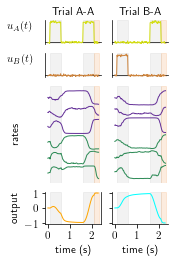

In [20]:
# Setting up task
dms.stimulus1_duration_min = 500
dms.stimulus1_duration_max = 500
dms.delay_duration_min = 1000
dms.delay_duration_max = 1000
dms.stimulus2_duration_min = 500
dms.stimulus2_duration_max = 500
dms.decision_duration = 200
dms.setup()
net.noise_std = noise_std

# Durations
stim1_beg = dms.fixation_duration_discrete
stim1_end = stim1_beg + dms.min_stimulus1_duration_discrete
stim2_beg = stim1_end + dms.min_delay_duration_discrete
stim2_end = stim2_beg + dms.min_stimulus2_duration_discrete
decision_end = stim2_end + dms.decision_duration_discrete
time = time_mapping(np.arange(decision_end))

# Figures parameters
col_sig1 = '#d3dd16'
col_sig2 = 'peru'
plot_w = 4

x1 = dms.generate_dms_data(1, type='A-A')[0]
x2 = dms.generate_dms_data(1, type='B-A')[0]

outp1, traj1 = net.forward(x1, return_dynamics=True)
outp2, traj2 = net.forward(x2, return_dynamics=True)
x1 = x1.squeeze().numpy()
x2 = x2.squeeze().numpy()
traj1 = traj1.detach().squeeze().numpy()
traj2 = traj2.detach().squeeze().numpy()
rates1 = np.tanh(traj1)
rates2 = np.tanh(traj2)
outp1 = outp1.detach().squeeze().numpy()
outp2 = outp2.detach().squeeze().numpy()

def plot_periods(ax):
    ax.axvspan(time_mapping(stim1_beg), time_mapping(stim1_end), color='silver', alpha=.2)
    ax.axvspan(time_mapping(stim2_beg), time_mapping(stim2_end), color='silver', alpha=.2)
    ax.axvspan(time_mapping(stim2_end), time_mapping(decision_end), color='sandybrown', alpha=.2)
    
    
fig, ax = plt.subplots(4, 2, figsize=(2.2, 3 * 1.25), gridspec_kw={'height_ratios': [.75, .75, 3, 1]})

ax[0][0].plot(time, x1[:, 0], c=col_sig1, zorder=30)
ax[0][0].spines['bottom'].set_position('zero')
ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False)
plot_periods(ax[0][0])
ax[0][0].set(xticks=[], ylim=(-.1, 1.1), yticks=[])
ax[0][0].set_ylabel('$u_A(t)$', rotation='horizontal')
ax[0][0].set_title('Trial A-A')

ax[1][0].plot(time, x1[:, 1], c=col_sig2, zorder=30)
ax[1][0].spines['bottom'].set_position('zero')
ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
plot_periods(ax[1][0])
ax[1][0].set(xticks=[], ylim=(-.1, 1.1), yticks=[])
ax[1][0].set_ylabel('$u_B(t)$', rotation='horizontal')

ax[0][1].plot(time, x2[:, 0], c=col_sig1, zorder=30)
ax[0][1].spines['bottom'].set_position('zero')
ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
plot_periods(ax[0][1])
ax[0][1].set(xticks=[], ylim=(-.1, 1.1), yticks=[])
ax[0][1].set_title('Trial B-A')

ax[1][1].plot(time, x2[:, 1], c=col_sig2, zorder=30)
ax[1][1].spines['bottom'].set_position('zero')
ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
plot_periods(ax[1][1])
ax[1][1].set(xticks=[], ylim=(-.1, 1.1), yticks=[])

neurons1 = np.random.choice(np.where(z==0)[0], 3)
neurons2 = np.random.choice(np.where(z==1)[0], 3)
neurons = np.concatenate([neurons1, neurons2])

colors_traces = 3*['seagreen'] + 3*['rebeccapurple']
helpers.plot_rates_single_neurons(rates1[:, neurons], offset=.3, colors=colors_traces, deltaT=dms.deltaT, ax=ax[2][0])
plot_periods(ax[2][0])
for spine in ('top', 'bottom', 'right', 'left'):
    ax[2][0].spines[spine].set_visible(False)
ax[2][0].set_yticks([])
ax[2][0].set_xticks([])
ax[2][0].set_ylabel('rates')

helpers.plot_rates_single_neurons(rates2[:, neurons], offset=.3, colors=colors_traces, deltaT=dms.deltaT, ax=ax[2][1])
plot_periods(ax[2][1])
for spine in ('top', 'bottom', 'right', 'left'):
    ax[2][1].spines[spine].set_visible(False)
ax[2][1].set_yticks([])
ax[2][1].set_xticks([])

ax[3][0].plot(time, outp1, c='orange')
plot_periods(ax[3][0])
ax[3][0].set(ylim=(-1.1, 1.1), yticks=[-1, 0, 1], xticks=[0, 1, 2], xlabel='time (s)', ylabel='output')
ax[3][0].spines['top'].set_visible(False)
ax[3][1].spines['right'].set_visible(False)

#ax[3][1].plot(time, outp2, c='#5cccff', lw=3)
ax[3][1].plot(time, outp2, c='cyan')
plot_periods(ax[3][1])
ax[3][1].set(ylim=(-1.1, 1.1), yticks=[-1, 0, 1], xticks=[0, 1, 2], yticklabels=['']*3,
            xlabel='time (s)')
ax[3][1].spines['top'].set_visible(False)
ax[3][1].spines['right'].set_visible(False)

fig.align_ylabels()
#plt.savefig('figures/5_dms_traces.pdf', bbox_inches='tight')

# Resampling

In [21]:
# Resample a few networks
new_size = 4096

losses_normal = []
accs_normal = []

n_samples = 10
net2 = clustering.to_support_net(net, np.zeros(hidden_size), new_size=new_size)
for _ in range(n_samples):
    net2.resample_basis()
    loss, acc = dms.test_dms(net2, x_val, y_val, mask_val)
    losses_normal.append(loss)
    accs_normal.append(acc)

losses2 = []
accs2 = []
net3 = clustering.to_support_net(net, z, new_size=new_size)
#train(net3, x_train, y_train, mask_train, 60, lr=1e-4, resample=True)
#torch.save(net.state_dict(), '../models/dms_retrained_2pop.pt')
net3.load_state_dict(torch.load('../models/dms_retrained_2pop.pt', map_location='cpu'))
for _ in range(n_samples):
    net3.resample_basis()
    loss, acc = dms.test_dms(net3, x_val, y_val, mask_val)
    losses2.append(loss)
    accs2.append(acc)
print(accs2)
    
net_rec = SupportLowRankRNN_withMask(2, 1024, 1, noise_std, alpha, rank=2, n_supports=2, gaussian_basis_dim=4)
net_rec.load_state_dict(torch.load('../models/dms_2pop_limit_cycle_reconstructed.pt', map_location='cpu'))
accs_rec = []
for _ in range(n_samples):
    net_rec.resample_basis()
    loss, acc = dms.test_dms(net_rec, x_val, y_val, mask_val)
    accs_rec.append(acc)

[1.0, 0.7599999904632568, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7250000238418579]


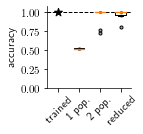

In [22]:
helpers.boxplot_accuracies([acc_orig, accs_normal, accs2, accs_rec], labels=['trained', '1 pop.', '2 pop.', 'reduced'],
                          figsize=(1.5, 1.5))
#plt.savefig('figures/5_dms_resampling.pdf', bbox_inches='tight')

/Users/avalente/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Use the colorbar set_ticks() method instead.


[None]

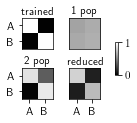

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(1.5, 1.5))

dms.psychometric_matrix(net, ax=ax[0][0])
dms.psychometric_matrix(net2, ax=ax[0][1])
dms.psychometric_matrix(net3, ax=ax[1][0])
dms.psychometric_matrix(net_rec, ax=ax[1][1])

for axx in ax[1]:
    axx.xaxis.tick_bottom()
    axx.set_xticks([0, 1])
    axx.set_xticklabels(['A', 'B'])

for axx in [ax[0][0], ax[1][0]]:
    axx.set_yticks([0, 1])
    axx.set_yticklabels(['A', 'B'])
    
ax[0][0].set_title('trained', pad=2)
ax[0][1].set_title('1 pop', pad=2)
ax[1][0].set_title('2 pop', pad=2)
ax[1][1].set_title('reduced', pad=2)

fig.subplots_adjust(hspace=.6, wspace=.3)

w = .03
h = .3
ax_cbar = fig.add_axes((1.01, .5 - h/2, w, h))
cmap = plt.get_cmap('gray')
matplotlib.colorbar.ColorbarBase(ax_cbar, cmap=cmap, orientation='vertical')
ax_cbar.set(yticks=[0, 1])
#plt.savefig('figures/5_dms_psycho.pdf', bbox_inches='tight')

# Phase portraits

In [24]:
def remove_axes(ax):
    ax.set(xticks=[], yticks=[])
    for spine in ['top', 'bottom', 'right', 'left']:
        ax.spines[spine].set_visible(False)

Text(0.5, 1.0, 'Input B')

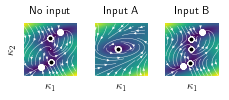

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(4*0.9, 1.2*.9))
ranktwo.plot_field(net, xmin=-2, xmax=2, ymin=-4, ymax=4, add_fixed_points=True, ax=ax[0],
                              fixed_points_trials=1, fp_load='../data/dms_fp1.npz', sizes=.5)

ranktwo.plot_field(net, xmin=-2, xmax=2, ymin=-4, ymax=4, input=torch.tensor([1., 0]), 
                              add_fixed_points=True, ax=ax[1],
                              fixed_points_trials=1, fp_load='../data/dms_fp2.npz', sizes=.5)

ranktwo.plot_field(net, xmin=-2, xmax=2, ymin=-4, ymax=4, input=torch.tensor([0, 1.]), 
                              add_fixed_points=True, ax=ax[2],
                              fixed_points_trials=1, fp_load='../data/dms_fp3.npz', sizes=.5)

for axx in ax:
    remove_axes(axx)
    axx.set_xlabel('$\kappa_1$')
    
ax[0].set_ylabel('$\kappa_2$')

ax[0].set_title('No input')
ax[1].set_title('Input A')
ax[2].set_title('Input B')

#plt.savefig('figures/5_dms_phase.pdf', bbox_inches='tight')